## Content

- What is imbalanced data?
- Imbalance data with KNN
  - Why Accuracy not used as metrics in Imbalance data
  - Alternative Metrics
  
- Imbalance data with Log-reg
- Handling Imbalance Data  
    - weighted loss
        - Implementation of Churn Prediction using weighted loss

    - Oversampling
    - Undersampling

-   SMOTE (Synthetically Minority Oversampling Technique)
- Implementation of Churn Prediction using SMOTE


### What is Imbalance data ? 

- We say data is imbalance, 
    - when the number of samples for particular class is more than the number of samples of the other classes.

Lets understand this with a Business Case study of Churn Prediction which we already covered in Logistic Regression.

Note: In the Logistic Regression lecture, the Churn Data we used was processed such that we removed the Imbalance present in the data 

Recapping the Problem Statement:
- The dataset is in telecom domain, that contains some Customer features such as {last month bill, usage , Account Length} 
- and we want to predict if the customer will churn or not 

#### what does churn mean?
- Lets take an example, 
- supposedly we are a customer of Airtel 
- and for some reason we have switched to another telecom company,
- Then we have churned as a customer 

#### Why even predict customer churn or not ?
- The Telecom company, after predicting those customers who will churn
- can reach out to them and provide offers such that they do not churn



#### Question: If we think of the dataset, how many Churn data samples will be there in the data ?
- Only a handful, hence the Churn data samples <<< the data samples of not Non Churn,
- hence making the data imbalanced. 

Now lets load the dataset:

In [ ]:
import pandas as pd
import numpy as np
from numpy import argmax

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score , f1_score, plot_confusion_matrix,classification_report

In [ ]:
!gdown 1rQPzACKn3SANJwBuJe_Wzk-B0sEGDRrW

Downloading...
From: https://drive.google.com/uc?id=1rQPzACKn3SANJwBuJe_Wzk-B0sEGDRrW
To: /content/Churn.csv
100% 289k/289k [00:00<00:00, 89.2MB/s]


In [ ]:
churn = pd.read_csv("Churn.csv")
churn.head()


Account Length  VMail Message  Day Mins  Eve Mins  Night Mins  Intl Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ Calls  Churn  Intl Plan  VMail Plan  ...  Day Charge  Eve Calls  \
0               1      0          0           1  ...       45.07         99   
1               1      0          0           1  ...       27.47        103   
2               0      0          0           0  ...       41.38        110   
3               2      0          1           0  ...       50.90         88   
4               3      0          1           0  ...       28.34        122   

   Eve Charge  Night Calls  Night Charge  Intl Calls  Intl Charge  State  \
0       16.78           91         11.01           3         2.70     KS   
1       16.62          103         11.45           3         3.70     OH   
2       10.30          104          7.32           5         3.29     NJ   
3        5.26           89          8.86           7         1.78     OH   
4       12.61          121          8.41           3         2.73     OK   

  Area Code     Phone  
0       415  382-4657  
1       415  371-7191  
2       415  358-1921  
3       408  375-9999  
4       415  330-6626  

[5 rows x 21 columns]

In [ ]:
churn.shape

(3333, 21)

Lets also check if there are any duplicates in the dataset

In [ ]:
if churn.shape[0] == churn.drop_duplicates().shape[0] :
    print('No duplicates Found')
else:
    duplicates = churn.shape[0] - churn.drop_duplicates().shape[0]
    print('{} duplicates found'.format(duplicates))

No duplicates Found


Checking for NULL values

In [ ]:
churn.isna().sum()

Account Length    0
VMail Message     0
Day Mins          0
Eve Mins          0
Night Mins        0
Intl Mins         0
CustServ Calls    0
Churn             0
Intl Plan         0
VMail Plan        0
Day Calls         0
Day Charge        0
Eve Calls         0
Eve Charge        0
Night Calls       0
Night Charge      0
Intl Calls        0
Intl Charge       0
State             0
Area Code         0
Phone             0
dtype: int64

- Notice how there is no null values in the dataset 

Recall how we used only a few features from the dataset which might not be the best ones to choose. 

- Considering the same 

In [ ]:
cols = ['Day Mins', 'Eve Mins', 'CustServ Calls', 'Intl Plan','VMail Message']
y = churn["Churn"]
X = churn[cols]
X.shape

(3333, 5)

Lets do a Count of samples for each Class labels

In [ ]:
churn["Churn"].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

- Notice how we have a few samples of Churn Data samples, and more samples of Not Churn Data samples


Spliting data in Train, Validation and test set

In [ ]:
# Train, CV, test split
from sklearn.model_selection import train_test_split
#0.6, 0.2, 0.2 split

X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_tr_cv, y_tr_cv, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
X_train.head()

Day Mins  Eve Mins  CustServ Calls  Intl Plan  VMail Message
1399     167.6     219.2               4          0              0
360      257.1     312.2               1          1              0
1136     270.3     215.2               1          1             26
2078     131.1     176.2               1          0              0
2011     194.2     193.8               3          0              0

### Imbalance data with kNN



- We have seen how outliers can affect the KNN model.


# **Can KNN get affected by Imbalanced data ?** 

Lets take an example:
- Supposedly we have a lot of +ve class labels datapoints as compared to -ve class labels data points
- We know, The value of K ranges from 1 to number of total datapoints in the data (n) 

#### Now if k = 7, what will KNN model predict for $x_q$ ?
- We see irrespective of where the $x_q$ will be, KNN will always predict $x_q$ as a +ve class label
- Since the majority of K nearest neighbors will be +ve class labels 











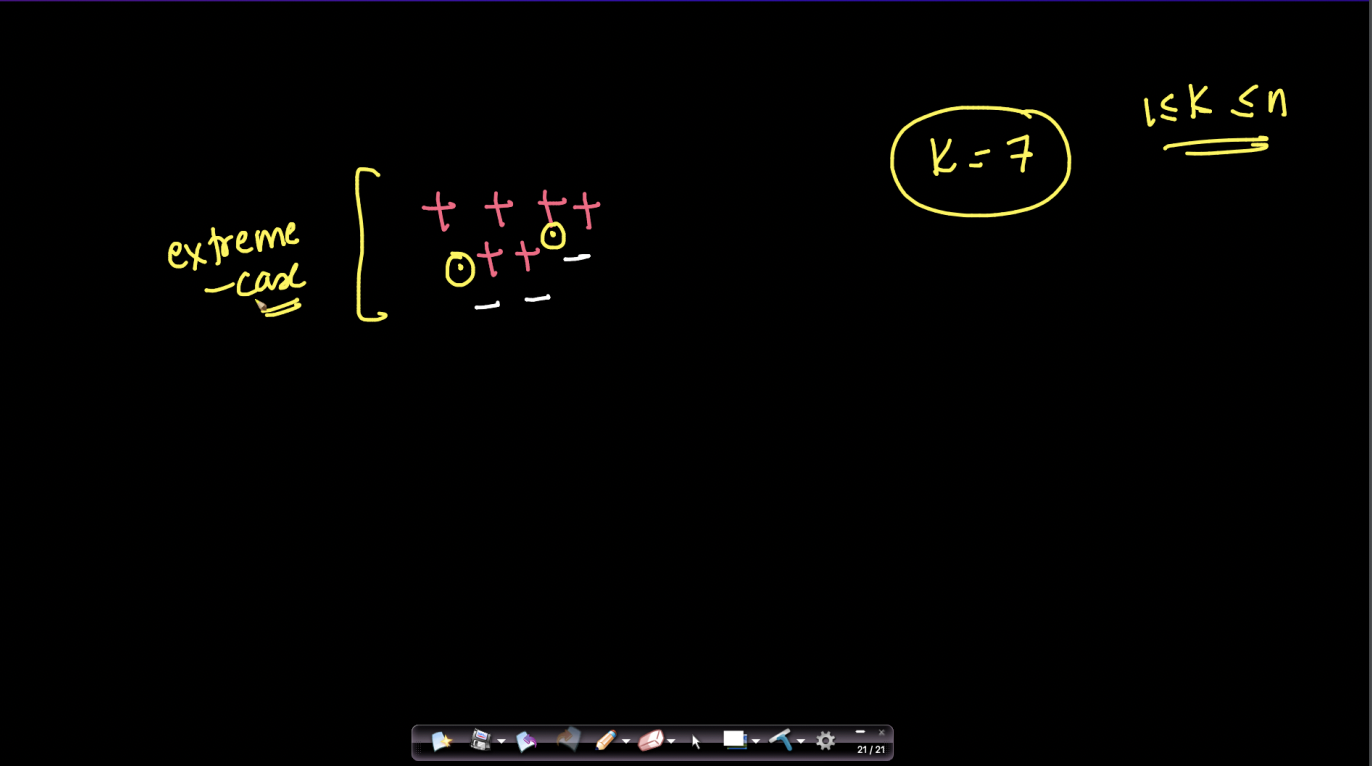

this shows that,
**when value of K is very large or close to number of datapoints(n)**,
- Data imbalance effects KNN model predictions

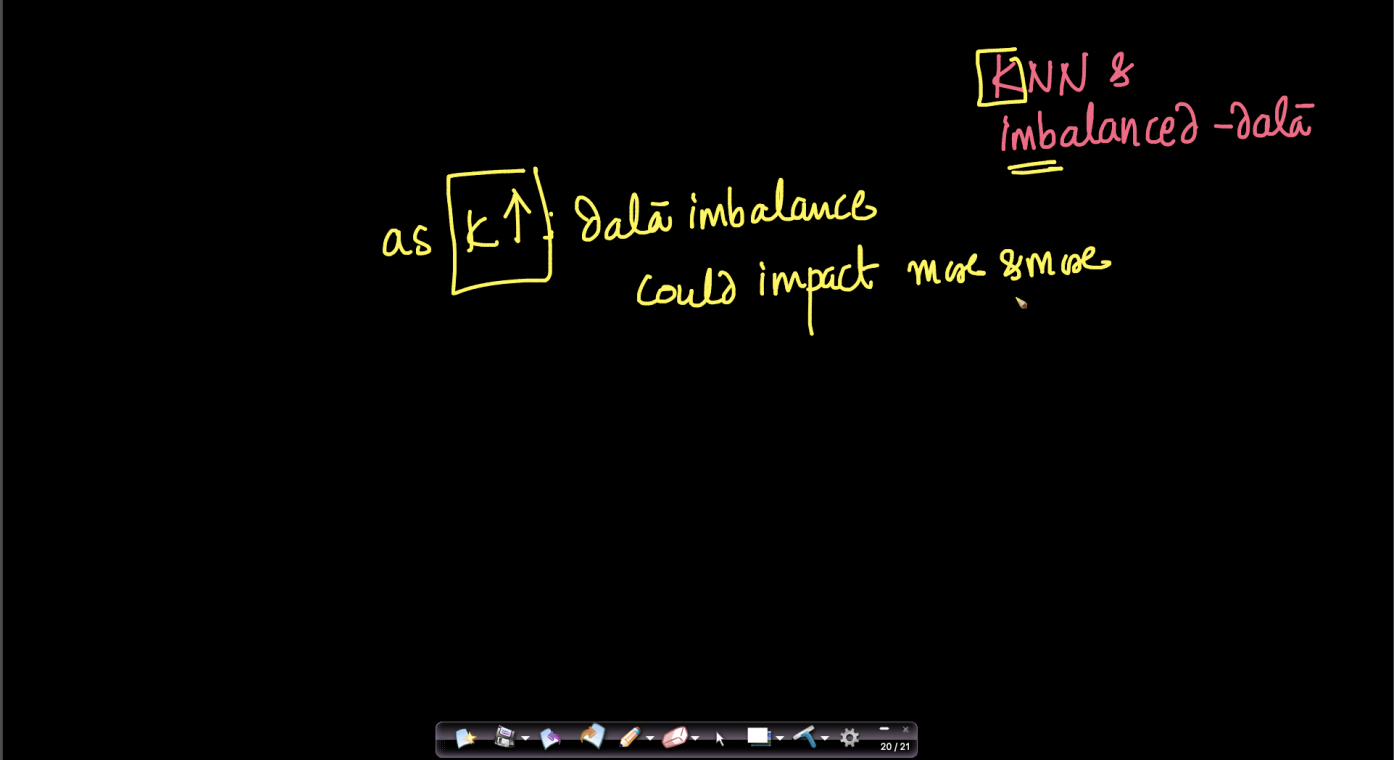

## **What if K<<n, will imbalance data impact KNN model predictions ?**

Lets take an example
- We again take a dataset where datapoints of +ve labels more than datapoints of -ve labels but we set K = 3, 
- now when we predict for $x_q$ (highlighted in pink dot), we see how the KNN will be predicting the class label as -ve
- even though we have a lot of +ve class label datapoints

hence when k << n , then imbalance impacts KNN much less 






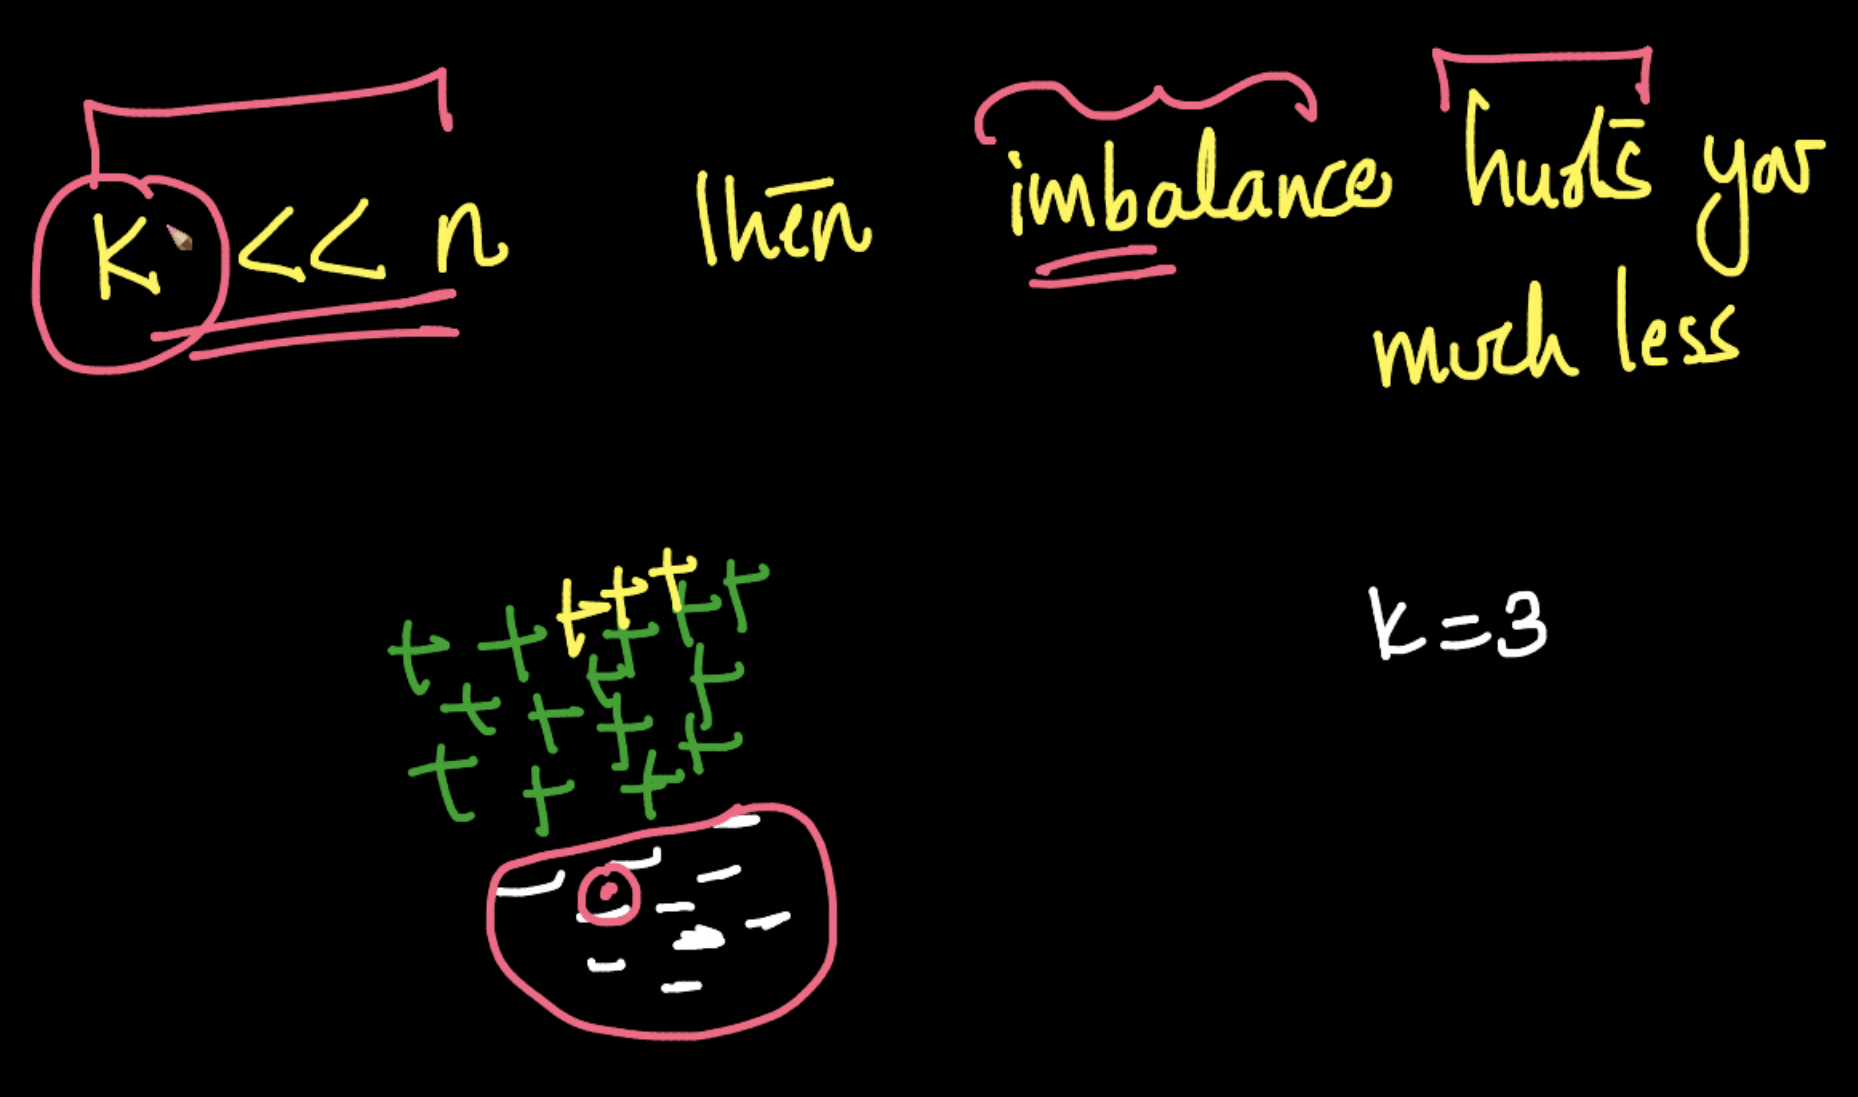

#### Lets check how KNN on our imbalanced Churn prediction Dataset 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Calculating  $K_{best}$
- with k values ranging: $1 \le k \le 50$

Note: Error defined as 1-accuracy

In [ ]:
error = []

# Calculating error for K values between 1 and 50
# Note: 51 is not included in the loop 
for i in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=i,metric='euclidean')
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_val)
    error.append(np.mean(pred_i != y_val))

Visualizing the error and K values

Text(0, 0.5, 'Mean Error')

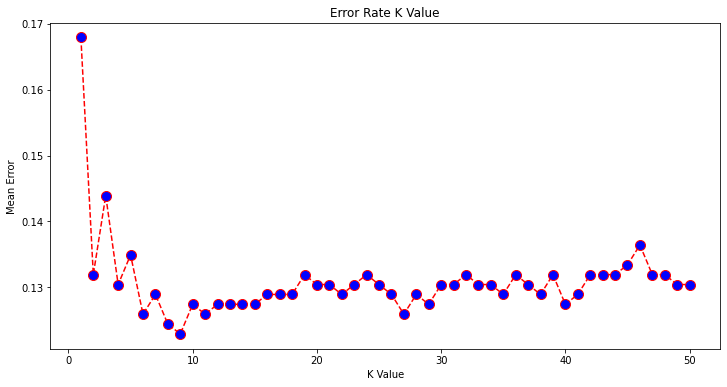

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 51), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

- Noticing that the first K value where Mean error is lowest is at K = 9,
- Hence $K_{best} = 9$

Note: The finding of $K_{best}$ was done on Validation Data

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9,metric='euclidean')

knn.fit(X_train, y_train)


KNeighborsClassifier(metric='euclidean', n_neighbors=9)

Accuracy of KNN on Test data

In [ ]:
y_pred = knn.predict(X_test)
knn.score(X_test, y_test)

0.9025487256371814

#### Question: Will Accuracy be the best metric to measure model performance in Imbalance Dataset ?

Recall from Classification Metrics, when we have imbalance data
- We do not use Accuracy as peformance metric 

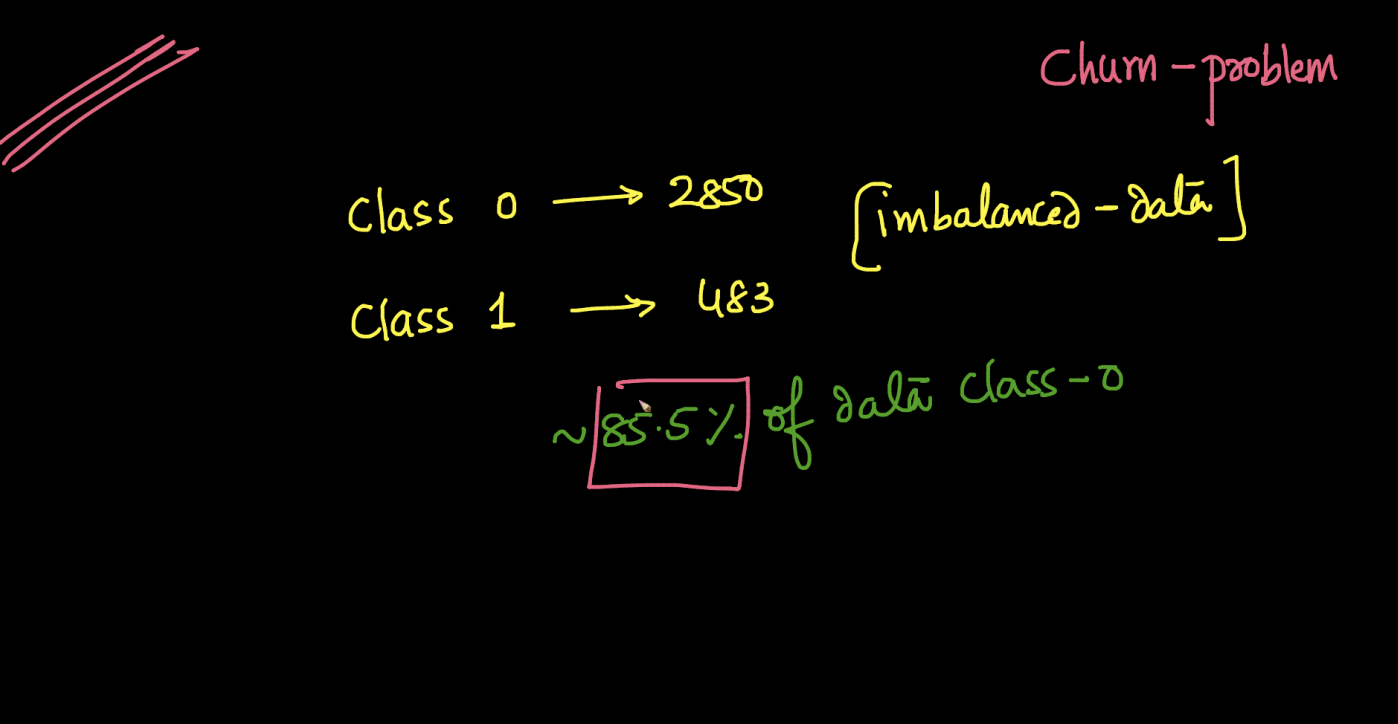

#### What if we want to use Accuracy as our only metric, How can we implement it ?
How about we measure Accuracy on each of the class samples. 

<br>


**For example :**

```
if we have 840 +ve samples and 150 -ve samples
- the model predicts 500 samples out of 840 as +ve samples 
- and 50 samples out of 150 as -ve samples.
```

Then the model accuracy for +ve class becomes $\frac{500}{840} = 0.59$
- And for -ve class : $\frac{50}{150} = 0.33 $

<br>

**Observe**

How Accuracy for each class can still help in evaluating the model performance even the data is imbalance.

<br>
 
#### But we cannot use two different accuracy values as a metric for evaluation, we need to combine it in some way, how can implement this ?

This can be implemented using a metric called Geometric Mean or G-mean.   
- Which is just a square root of the product of Specificity and Senstivity of the whole data   
 - $G-mean = \sqrt{Specificity \times Sensitivity}$

For our previous example:

```
Specificity = 50/150

Senstivity = 500/600

Hence G-Mean = sqrt(0.277) = 0.53

```

Thus showing the model did a slightly better job than a mean model. 
- Hence G-mean can be used as a performance metric 
- to measure model performance when data is imbalance 

<br>

Lets Implement G-Mean 
- but first lets look at the Confusion matrix 

Confusion Matrix of KNN on Test Data

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,index = np.unique(y_test), columns = np.unique(y_test) )

cm_df.head()

0   1
0  560   6
1   59  42

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x576 with 0 Axes>

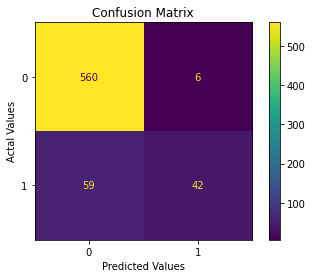

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(knn,X_test,y_test)
#sns.heatmap(cm_df, annot=True,cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Now lets calculate G-mean

In [ ]:
def g_mean(conf_mat):
    tp = float(conf_mat[1][1])
    tn = float(conf_mat[0][0])
    fp = float(conf_mat[0][1])
    fn = float(conf_mat[1][0])
    
    spec = tn/(tn+fp)
    sens = tp/(tp+fn)
    
    g_mean = (spec*sens)**(0.5)
    print(f"G-mean: {g_mean}")


In [ ]:
g_mean(cm)

G-mean: 0.6414307207215433


**Observe**

how KNN gets a G-Mean of 64.14% which shows KNN is performing poorly in classifying the samples of each of the class 
- but still lacks in accurately classifying the data.

With G-mean, we know KNN is impacted by Imbalance data, 

<br>

#### but what is the reason KNN is being impacted by the imbalance in data ?

Recall from Classification Metrics, F1-score is used when data is imbalance
- And how F1-score is used when Precision and Recall are both important to us,

<br>

Lets check if F1-score can help figuring the reason behind the weak performance of KNN

In [ ]:
f1_score(y_test,y_pred)

0.5637583892617449

**Observe** 

We can see KNN is impacted by Imbalance in Churn Dataset 
- but still F1-score does not tell the exact reason why KNN is getting impacted

#### Now what if, the model performed bad due to more False Negative or False Positives How can we measure that ? 

For measuring the false negative impact, we use F0.5 score 
- $F0.5 = \frac{(1+0.5^2)*precision*recall}{(0.5^2)precision+recall}$

And for measuring the false positive impact, we use F2 score 
- Defined as: $F2 = \frac{(1+2^2)*precision*recall}{(2^2)*precision+recall}$

<br>

Now lets see if the KNN model performed bad due to False Negative or False Positive using F0.5 and F2 Score 



We will be using the Sklearn [fbeta_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function 
- and define the parameter ```beta``` as 2 for f2-Score
- ```beta``` as 0.5 for f0.5-Score

In [ ]:
from sklearn.metrics import fbeta_score

def cal_fscore(m_1):
    y_pred = m_1.predict(X_test)
    f2 = fbeta_score(y_test,y_pred,beta=2)
    f0 = fbeta_score(y_test,y_pred,beta=0.5)
    f1 = f1_score(y_test,y_pred)
    print(f"F2: {f2}")
    print(f"F0.5: {f0}")
    print(f"F1: {f1}")

In [ ]:
cal_fscore(knn)

F2: 0.46460176991150437
F0.5: 0.7167235494880546
F1: 0.5637583892617449


**Notice** 

how the F2 metrics is low, indicating the imbalance data impacts the KNN 
- such that there are more False Negative 

# **Imbalance Data with Logistic Regression**




For Churn Prediction lets say, 

- in our training data, we have 850 non churn (0) samples and 150 churn (1) samples.

- Now if there is a hyperplane Π that separates the dataset,

- Recall, how in logistic regression, we minimize the loss function which was the summation of log-loss over the entire data sample (n).
 - Loss = $∑_{i=1}^{i=n} logloss_i$

#### But since -ve class samples much greater than +ve class samples, What will be the effect on the loss function?
- The -ve class sampled data dominates the loss functions
- This makes the hyperplane Π to be pushed away from the -ve class data points
- Since the -ve class labels will want to be as further away from the hyperplane as possible.
- thus the model favors -ve class label points and ignores the +ve class label

Notice, how Imbalance data also effects Logistic Regression model, 

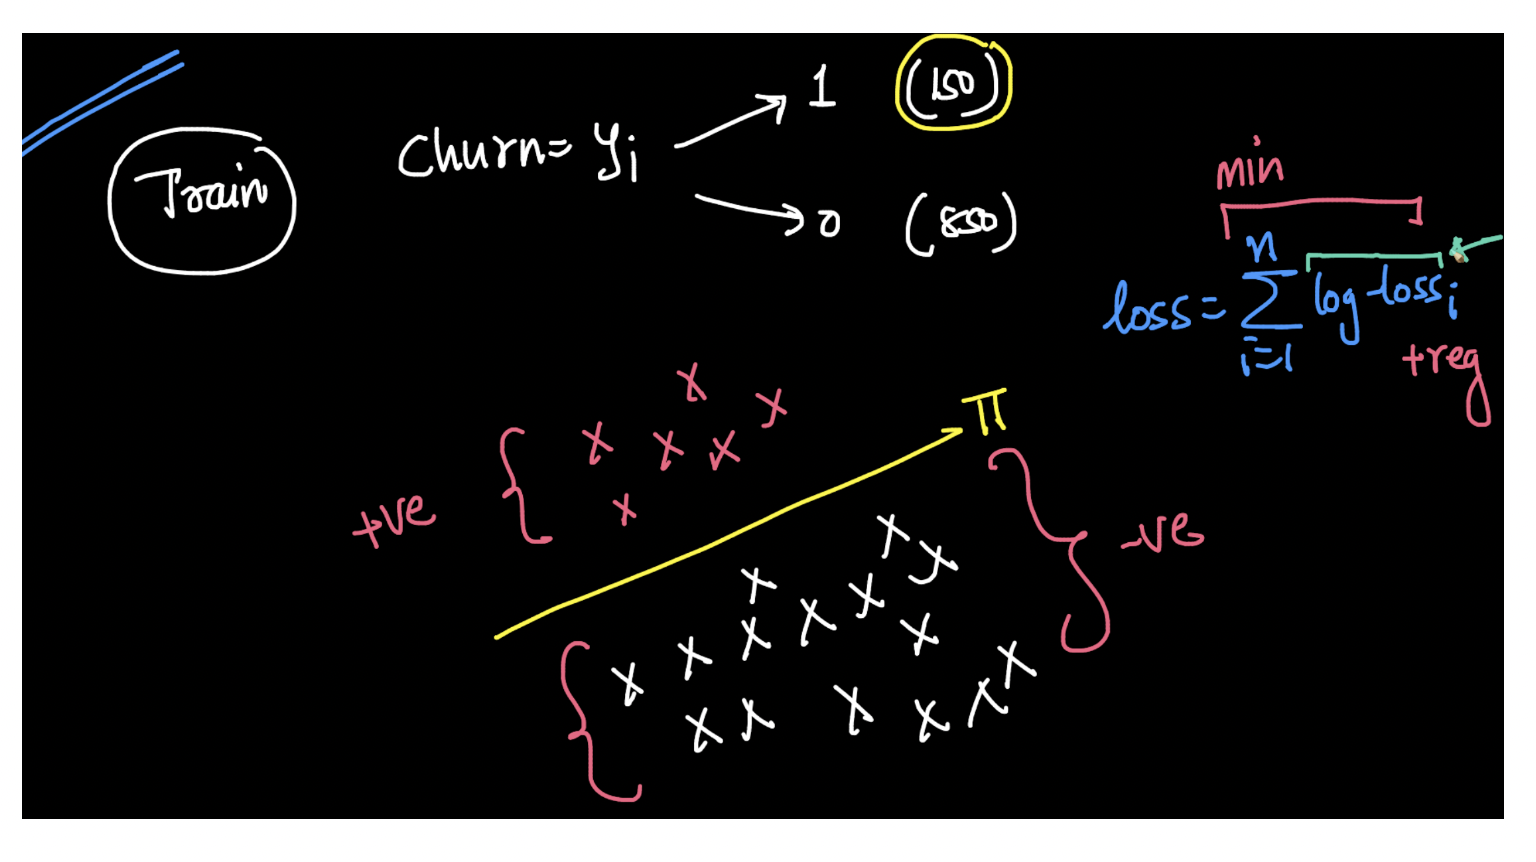


Lets now see how its implemented in SKlearn for Logisitic Regression
- Since we cannot use Accuracy, We will be using F1-Score as metric for comparing the best Regularization Parameter (λ).

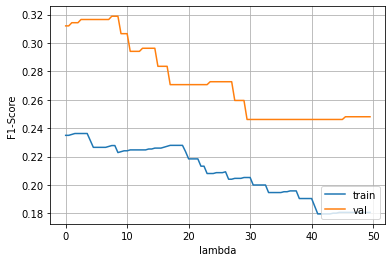

In [ ]:
# Hyper-pram tuning without any rebalancing 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

train_scores = []
val_scores = []
scaler = StandardScaler()
l = 0.01
h = 50.0
d = 0.5

for la in np.arange(l,h,d):
  scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/la))
  scaled_lr.fit(X_train, y_train)
  train_y_pred = scaled_lr.predict(X_train)
  val_y_pred = scaled_lr.predict(X_val)
  train_score = f1_score(y_train, train_y_pred)
  val_score = f1_score(y_val, val_y_pred)
  train_scores.append(train_score)
  val_scores.append(val_score)

plt.figure()
plt.plot(list(np.arange(l,h,d)), train_scores, label="train")
plt.plot(list(np.arange(l,h,d)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("lambda")
plt.ylabel("F1-Score")
plt.grid()
plt.show()

In [ ]:
best_idx = np.argmax(val_scores)
print(val_scores[best_idx])

0.31884057971014496


Training the best Logistic Regression model

In [ ]:
# Model with lambda_best
best_idx = np.argmax(val_scores)
l_best = l+d*best_idx
scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/l_best))
scaled_lr.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.13315579227696406))])

Predicting the model performance using all the different metrics

In [ ]:
y_pred = scaled_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,index = np.unique(y_test), columns = np.unique(y_test) )

cm_df.head()

0   1
0  551  15
1   85  16

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x576 with 0 Axes>

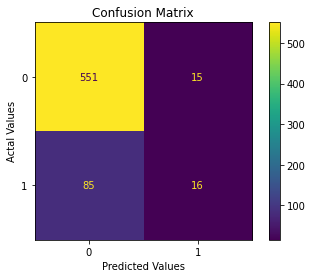

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(scaled_lr,X_test,y_test)
#sns.heatmap(cm_df, annot=True,cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
g_mean(cm)

cal_fscore(scaled_lr)

G-mean: 0.3927054136315571
F2: 0.1839080459770115
F0.5: 0.35555555555555557
F1: 0.24242424242424243


**Observe** 

how the model has performed poorly without the weighted log-loss 
- As the best F1-Score for validation is only 32%

<br>

This shows that we need to handle the Imbalance data for both KNN and Logisitic Regression

# **Handling Imbalance Data**


## **Weighted Loss**
#### Now that we know, imbalance data impacts model performance whether it being KNN or Logistic Regression, is there a way to handle imbalance data ?

We notice how Imbalance data causes issues on the loss function.



### **Can we manupilate the loss function such that it incooporates Imbalance data case too ?**
-  We can a class-weight to the log-loss function which will be a constant
 - loss = $∑_{i=1}^{i=1000}logloss_i .w_i$

#### how to calculate this class-weight ?
- we see , we have 850 -ve class samples and 150 +ve class samples.
- Hence $w_i$ can be defined as the ratio of class with more number of samples to the class with less number of samoples $ w_i = \frac{850}{150} ≈ 6 $  

- Since +ve class has less samples, we say $w_i = 6$
- And for -ve class, we say $w_i = 1$ 



Note: this approach is done on the model parameters.


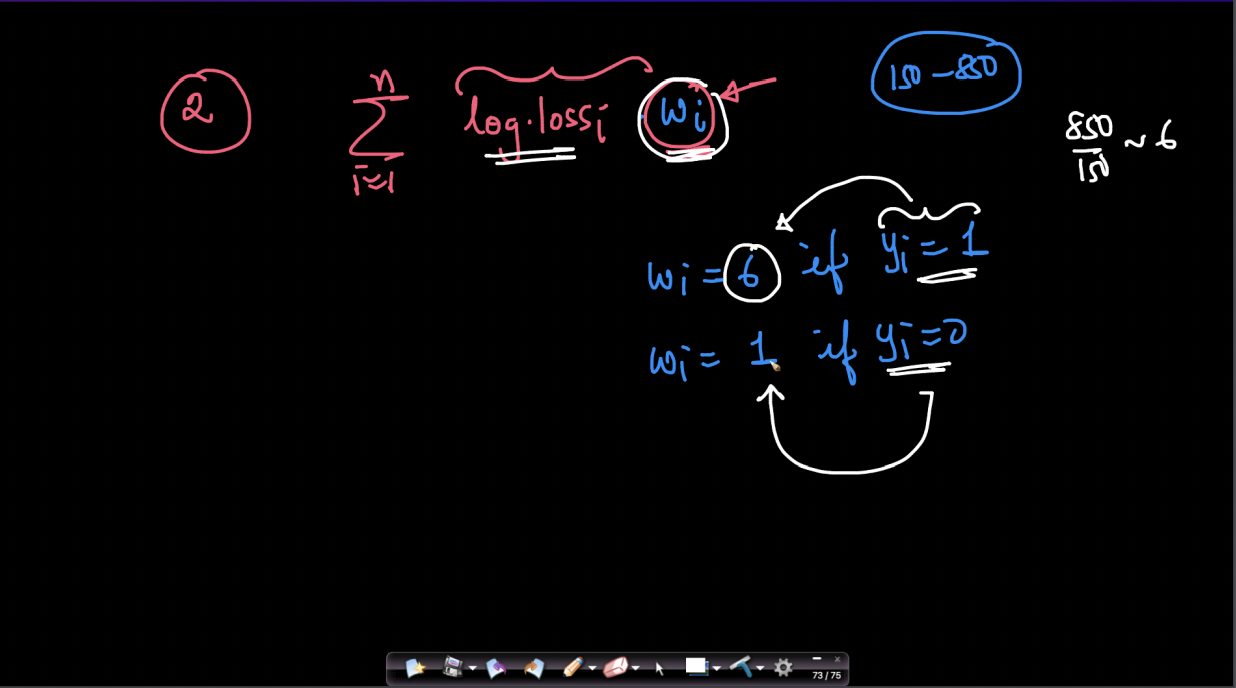

#### Implementation of Churn Prediction using weighted loss


Lets now see how its implemented in SKlearn for Logisitic Regression
- Since we cannot use Accuracy, We will be using F1-Score as metric for comparing the best Regularization Parameter (λ).

we will be adding class weights to each of the class labels
- For Not Churn $y_i = 0$, 
    - $w_0 = 1 $  
- For Churn $y_i = 1$,    
    - $w_1 = \frac{2850}{483} = 5.9 ≈ 6 $  

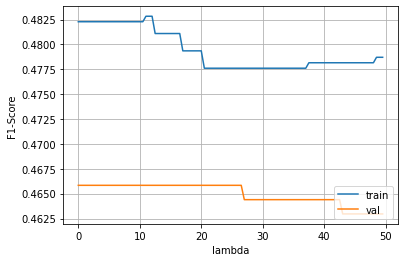

In [ ]:
# minority class needs more re-weighting 

# Hyper-pram tuning
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

train_scores = []
val_scores = []
scaler = StandardScaler()
l = 0.01
h = 50.0
d = 0.5

for la in np.arange(l,h,d):
  scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/la, class_weight={ 0:1, 1:6 }))
  scaled_lr.fit(X_train, y_train)
  train_y_pred = scaled_lr.predict(X_train)
  val_y_pred = scaled_lr.predict(X_val)
  train_score = f1_score(y_train, train_y_pred)
  val_score = f1_score(y_val, val_y_pred)
  train_scores.append(train_score)
  val_scores.append(val_score)

#plotting
plt.figure()
plt.plot(list(np.arange(l,h,d)), train_scores, label="train")
plt.plot(list(np.arange(l,h,d)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("lambda")
plt.ylabel("F1-Score")
plt.grid()
plt.show()

In [ ]:
best_idx = np.argmax(val_scores)
print(val_scores[best_idx])

0.46583850931677023


**Observe**

how introducing Weighted-loss, 
- increased the F1-score

<br>


Using the best  Regularization parameter and the class-weight, 
- we see the performance of the model on test data


In [ ]:
# Model with lambda_best
best_idx = np.argmax(val_scores)
l_best = l+d*best_idx
scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/l_best, class_weight={ 0:1, 1:6 }))
scaled_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=100.0, class_weight={0: 1, 1: 6}))])

Let's look at this confusion matrix for the data.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(y_test, scaled_lr.predict(X_test))
print(conf_mat)

[[439 127]
 [ 23  78]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x576 with 0 Axes>

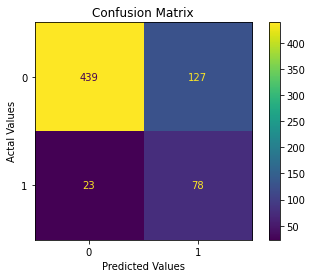

In [ ]:

#Plotting the confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(scaled_lr,X_test,y_test)
#sns.heatmap(cm_df, annot=True,cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

- Notice, how after weighted log-loss, the model is quite good in classifying most of the data correctly

Lets look into the other metrics as well

In [ ]:
g_mean(conf_mat)
cal_fscore(scaled_lr)

G-mean: 0.773945998164426
F2: 0.6403940886699506
F0.5: 0.4234527687296417
F1: 0.5098039215686274


**Observe**

How After using Weighted Logistic Regression
- the G-mean, F2, F0.5 and F1 score of the model increased, 

showing that the model performed quite well

#### Lets check how class weight on KNN impacts the model performance

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Calculating  $K_{best}$
- with k values ranging: $1 \le k \le 50$

Note: Error defined as 1-accuracy

In [ ]:
error = []

# Calculating error for K values between 1 and 50
# Note: 51 is not included in the loop 
for i in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=i,metric='euclidean', weights='distance' )
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_val)
    error.append(np.mean(pred_i != y_val))

Visualizing the error and K values

Text(0, 0.5, 'Mean Error')

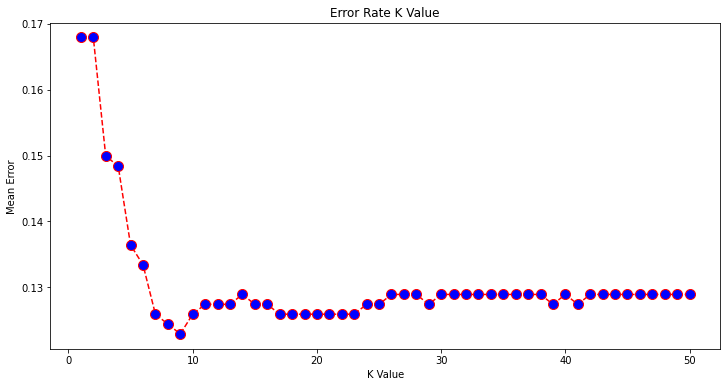

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 51), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

- Noticing that the first K value where Mean error is lowest is at K = 9,
- Hence $K_{best} = 9$

Note: The finding of $K_{best}$ was done on Validation Data

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9,metric='euclidean',weights='distance')

knn.fit(X_train, y_train)


KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')

In [ ]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,index = np.unique(y_test), columns = np.unique(y_test) )

cm_df.head()

0   1
0  559   7
1   61  40

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x576 with 0 Axes>

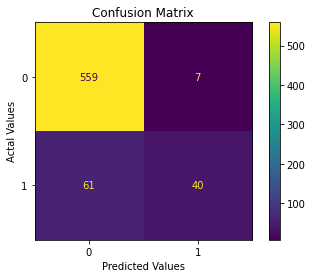

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(knn,X_test,y_test)
#sns.heatmap(cm_df, annot=True,cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Now lets calculate the different Metrics

In [ ]:
g_mean(cm)
cal_fscore(knn)

G-mean: 0.6254131335821138
F2: 0.4434589800443459
F0.5: 0.6920415224913495
F1: 0.5405405405405406


**Observe**

For KNN the weighted loss, did not improve the perfromance of the model

Lets look into more Handling approaches

# **Oversampling**



#### Now what if we only wanted to change on the data, to make it balanced ?

- The first approach is , if we replicating the samples of the +ve labels such that it becomes almost same as the -ve labels.

- Now if we Replicate the 150 samples 6 times, we get 900 samples for +ve class label.

- This makes our total number of samples (n) as 850+900  = 1750

hence our loss function becomes 
- loss = $∑_{i=1}^{i=1750}log-loss_i $ 


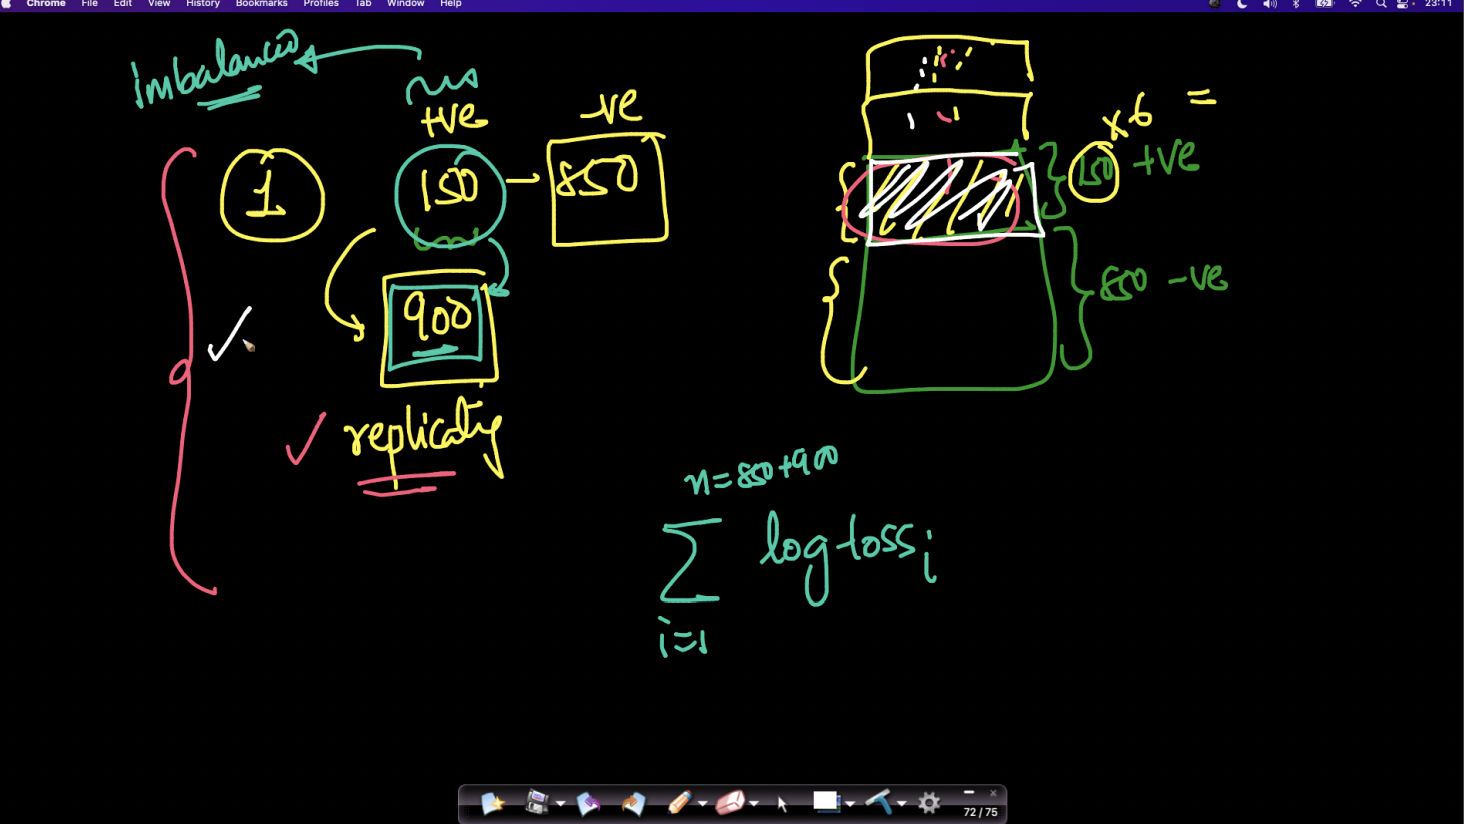

# **Undersampling**

- The other approach is to remove datapoints/samples of the -ve class label (since more in number)
- such that Datapoints of -ve class label is equal to the datapoints of +ve class label.

#### But does reducing the data cause data information loss ?
- Yes, with such information loss, it reduces the model reliability

- Hence we do Undersampling, only when the number of datapoints/samples(n) are really large( apporx. 1 billion)



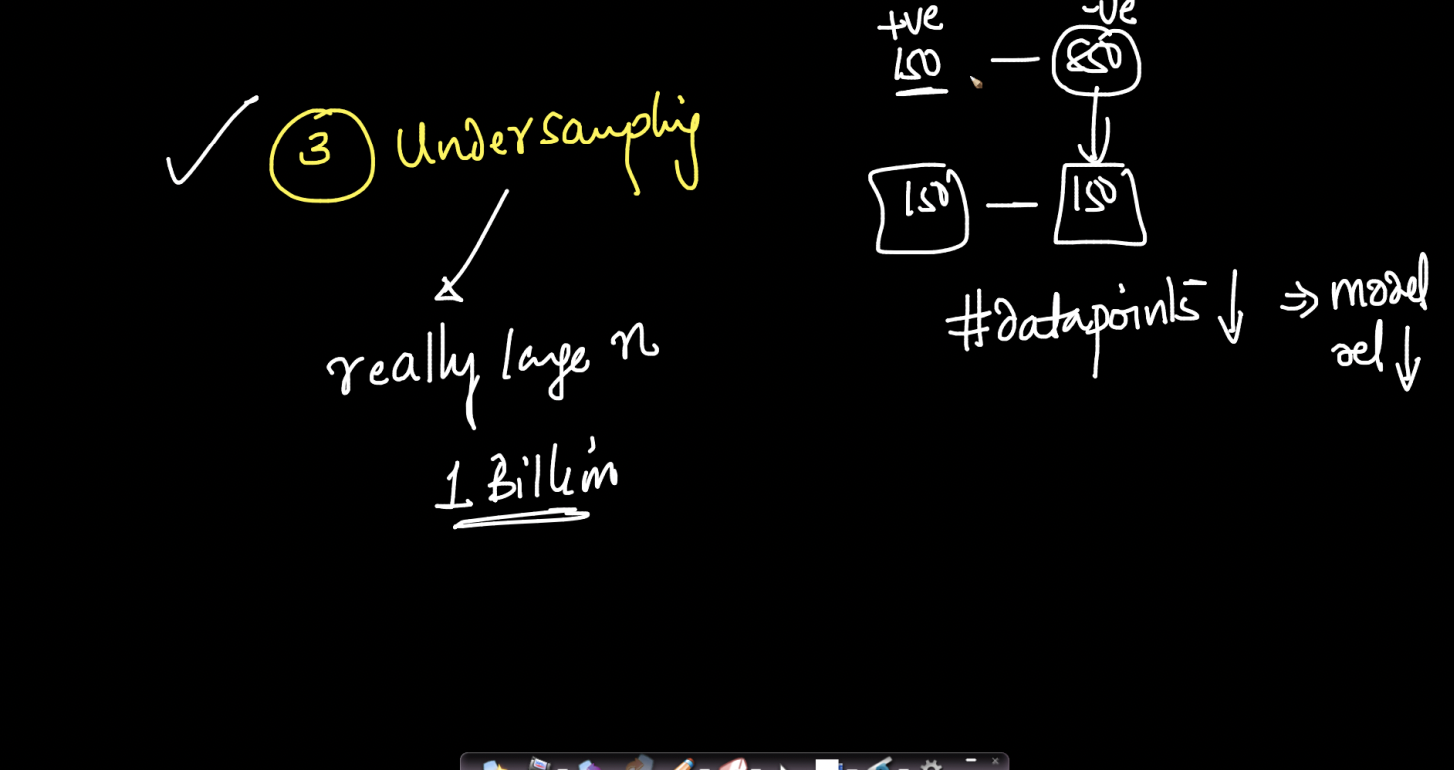

# **SMOTE (Synthetically Minority Oversampling Technique)**


<center><img src="https://drive.google.com/uc?id=16IjdHQqcddwUOtbOzVYrQufofftbOReZ" width="1000" height="300"> </center>

- Notice how in oversampling data we were just repeating the data

#### Can we a bit more smart about the oversampling approach and use something like K Nearest Neighbors based approach?

Lets assume we have an imbalanced dataset having a large number of +ve labels samples and a few number of -ve labels samples
- Lets take k = 3, and we take a random point $x_1$  on the -ve class label.
    - now for i which varies from 1 to k
    - we compute the distance ($d_{1,2}$) between $x_1$ and the 1st nearest neighbor $x_2$ using the different distance metrics 
    - Now we select a random value between [0,1], lets assume we select 0.2 
    - with these values, we create a new datapoint $x_{new} = x_1 + 0.2 d_{1,2}$
    - Now we will add this $x_{new}$ to the dataset with class label as -ve
    - We repeat this, for the other Nearest Neighbors   


#### how is SMOTE better than oversampling ?
- In oversampling, we are simply repeating the data
- But now we are synthetically creating new data



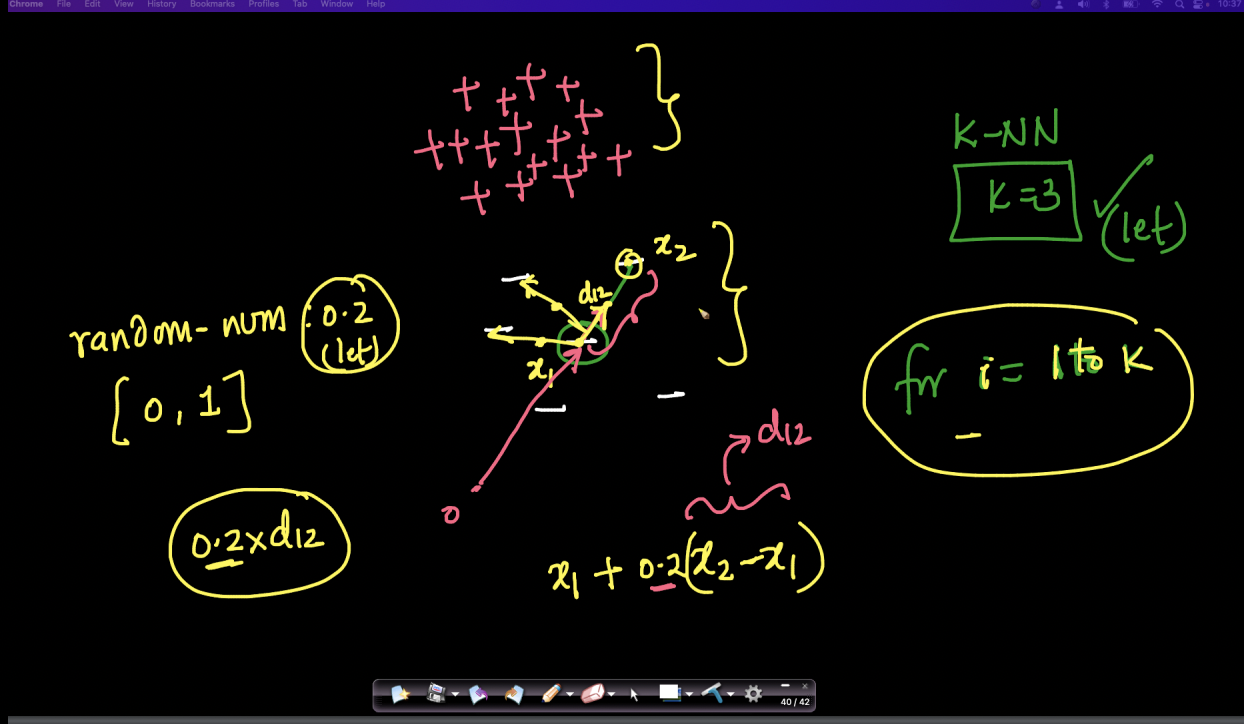

- So in short, if we have three datapoints $x_1,x_2,x_3$ with all -ve class labels,
- SMOTE uses K nearest neighbors approach to add a new synthetic  nearest neighbor datapoint between the original datapoints.here look how, 
    - SMOTE adds $x_{new}^1$ between $x_1$ and $x_2$ 
    - While $x_{new}^2$ between $x_3$ and $x_1$  

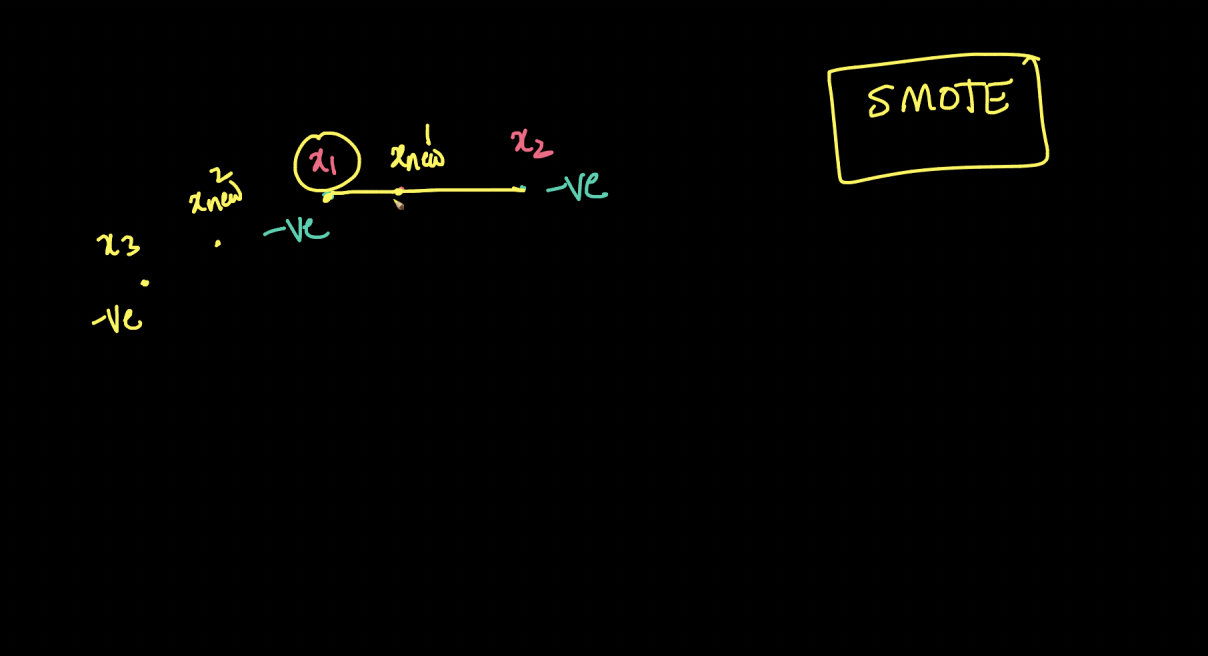

### Implementation of Churn Prediction using [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smt = SMOTE()
X_sm, y_sm = smt.fit_resample(X_train, y_train)

print('Resampled dataset shape {}'.format(Counter(y_sm)))

Resampled dataset shape Counter({0: 1718, 1: 1718})


- Notice how the data has been resampled using synthetic data, such that
 - Churn samples $y=1$ are now same as the Not Churn $y=0$ Samples 



In [ ]:
X_sm.shape,y_sm.shape

((3436, 5), (3436,))

**Observe**

The shape of X_sm is just 1718 × 2 
- showing how SMOTE oversampled the minority class 

starting with the implementation of Logistic Regression




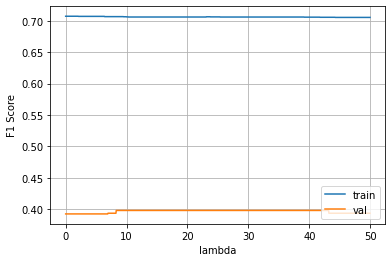

In [ ]:
# Hyper-pram tuning without any rebalancing 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


train_scores = []
val_scores = []
scaler = StandardScaler()
l = 0.01
h = 50.0
d = 0.05

for la in np.arange(l,h,d):
  scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/la))
  scaled_lr.fit(X_sm, y_sm)
  train_score = f1_score(y_sm, scaled_lr.predict(X_sm))
  val_score = f1_score(y_val, scaled_lr.predict(X_val))
  train_scores.append(train_score)
  val_scores.append(val_score)

plt.figure()
plt.plot(list(np.arange(l,h,d)), train_scores, label="train")
plt.plot(list(np.arange(l,h,d)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("lambda")
plt.ylabel("F1 Score")
plt.grid()
plt.show()

- From this we now find the best Regularization Parameter for Logistic Regression

In [ ]:
best_idx = np.argmax(val_scores)
print(val_scores[best_idx])

0.39779005524861877


Using the best Logistic Model for Test data

And predicting the test accuracy

In [ ]:
# Model with lambda_best
best_idx = np.argmax(val_scores)
l_best = l+d*best_idx
scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/l_best))
scaled_lr.fit(X_sm, y_sm)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.12033694344163658))])

### Notice how Logistic Regression model F1-score is pretty bad on the test data, Why is that ?

lets have a check on the other metrics as well:

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


conf_mat = confusion_matrix(y_test, scaled_lr.predict(X_test))
print(conf_mat)

[[394 172]
 [ 21  80]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x576 with 0 Axes>

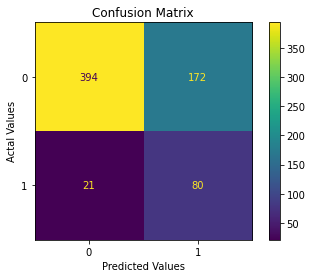

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(scaled_lr,X_test,y_test)
#sns.heatmap(cm_df, annot=True,cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Measuring from different Metrics

In [ ]:
g_mean(conf_mat)
cal_fscore(scaled_lr)

G-mean: 0.742547434471066
F2: 0.6097560975609756
F0.5: 0.36068530207394045
F1: 0.45325779036827196


**Observe**
 
using SMOTE 
- the False Positive and False Negative increased 

This means for Logisitic Regression
- Showing how Class weight works much better for Logistic Regression 

- Notice how all the other metrics shows the same 
- That using the Weighted logloss than SMOTE makes Logistic Regression model perform much better

- Now lets look how SMOTE Oversampling works for KNN 

#### KNN

Finding the best K

In [ ]:
error = []

# Calculating error for K values between 1 and 50
# Note: 51 is not included in the loop 
for i in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=i,metric='euclidean')
    knn.fit(X_sm, y_sm)
    pred_i = knn.predict(X_val)
    error.append(np.mean(pred_i != y_val))

Text(0, 0.5, 'Mean Error')

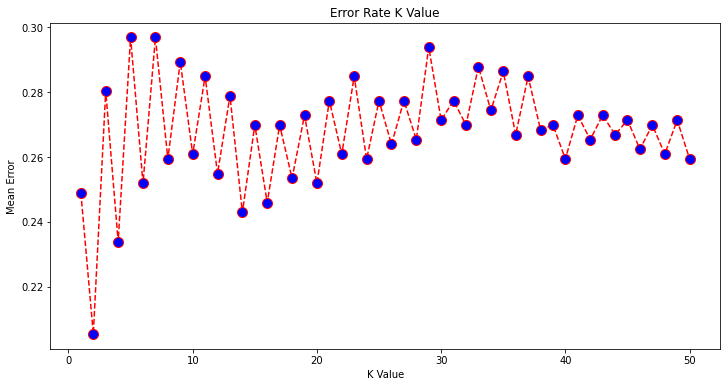

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 51), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

- Notice how the the best K value is when $K_{best}$=2

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2,metric='euclidean')

knn.fit(X_sm, y_sm)


KNeighborsClassifier(metric='euclidean', n_neighbors=2)



Lets see the Confusion Matrix on better evaluating the model

In [ ]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,index = np.unique(y_test), columns = np.unique(y_test) )

cm_df.head()

0   1
0  507  59
1   55  46

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x576 with 0 Axes>

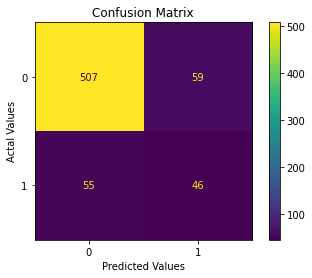

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(knn,X_test,y_test)
#sns.heatmap(cm_df, annot=True,cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Lets measure the different metrics

In [ ]:
g_mean(cm)
cal_fscore(knn)

G-mean: 0.63872511477336
F2: 0.4518664047151278
F0.5: 0.4414587332053743
F1: 0.44660194174757284


- This shows that using Weighted loss and different metrics we can evaluate the model much better, 
- and SMOTE is not the only correct way to tackle imbalanced data